# docs

In [8]:
#!/usr/bin/env python

__author__ = "Sushil Sivaram, Megha Gubbala", "Sylvia Nanyangwe"
__copyright__ = "N/A"
__credits__ = ["Isac Artzi", "Dinesh Sthapit", "Ken Ferrell", "James Dzikunu", "Tracy Roth", "Renee Morales"]
__license__ = "ECL"
__maintainer__ = "Sushil Sivaram, Megha Gubbala", "Sylvia Nanyangwe"
__email__ = "SushilSivaram@gmail.com"
__status__ = "Development"

# This section shows the imports used by the code

In [9]:
from matplotlib import pyplot
from scipy import stats
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.features import Rank2D
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ConfusionMatrix
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import scikitplot as skplt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import FileLink
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA

# Define Variables

In [10]:
load_dotenv()
CSVData = os.getenv('CSVOriginal')
DependentVariable = os.getenv('DependentVariable')
head_Value = int(os.getenv('Head_Value'))
testSize = float(os.getenv('test_size'))
randomstate = int(os.getenv('random_state'))

# Setup Reusable Functions

In [11]:

# Load Data from CSV
def loadAndExtractData():
    global dataSetUp
    global datasetupUnprocessed
    dataSetUp = pd.read_csv(CSVData)
    datasetupUnprocessed = dataSetUp
    keepcolumns = [#'LL95_affordability_ratio', 'UL95_affordability_ratio',
                   'race_eth_code','median_income','affordability_ratio', 'ave_fam_size']
    dataSetUp =dataSetUp.filter(keepcolumns)
    for keep in keepcolumns:
        dataSetUp = dataSetUp[dataSetUp[keep].notna()]
    dataSetUp= dataSetUp[(np.abs(stats.zscore(dataSetUp)) < 3).all(axis=1)]
    dataSetUp.to_csv('cleaned.csv', index=False)
    display(FileLink('cleaned.csv'))
    print (dataSetUp.shape)


#print Info
def showDataHeadAndInfo(data,headCount):
    print(f"showing head {headCount} values")
    print(data.head(headCount))
    print("**********")
    print("Showing info of dataset")
    print(data.describe(include='all'))


# preProcessing
def preProcessing():
    bins = (0, .2, 5)
    group_names = ['Cant Afford', 'Can Afford']
    dataSetUp[DependentVariable] = pd.cut(dataSetUp[DependentVariable], bins, labels=group_names)
    dataSetUp.to_csv('test.csv')
    label_quality = LabelEncoder()
    dataSetUp[DependentVariable] = label_quality.fit_transform(dataSetUp[DependentVariable])
    #showDataHeadAndInfo(head_Value)
    print(dataSetUp[DependentVariable].value_counts())


#plotting
def plotting(dataSetUp, state):
    plt.figure()
    histmedian_income = dataSetUp['median_income'].plot.hist(bins=25, grid=True, rwidth=0.9, color='#607c8e')
    plt.title(f'Histogram of Median Income {state}')
    plt.xlabel('Median Income in $')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.5)
    histmedian_income.figure.savefig(f'.\outputs\histMedianIncome{state}.png')

    plt.figure()
    hist_avg_fam = dataSetUp['ave_fam_size'].plot.hist(bins=25,  grid=True, rwidth=0.9, color='#607c8e')
    plt.title(f'Histogram of Family Size {state}')
    plt.xlabel('Family Size')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.5)
    hist_avg_fam.figure.savefig(f'.\outputs\histavgFamsize{state}.png')

    plt.figure()
    hist_race_eth_name = dataSetUp['race_eth_code'].plot.hist(bins=2, grid=True, rwidth=0.9, color='#607c8e')
    plt.title(f'Histogram race distribution {state}')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.5)
    hist_race_eth_name.figure.savefig(f'.\outputs\histCost{state}.png')

    plt.figure()
    scattermedian_income = dataSetUp.plot.scatter(c='DarkBlue', x='median_income', y = 'ave_fam_size' )
    plt.title(f'scatterogram of Median Income vs Expenditure {state}')
    plt.xlabel('Median Income in $')
    plt.ylabel('ave_fam_size')
    plt.grid(axis='y', alpha=0.5)
    scattermedian_income.figure.savefig(f'.\outputs\scatterMedianIncomeVSFamilySize{state}.png')

    plt.figure()
   # scattermedian_income = dataSetUp.plot.scatter(c='DarkBlue', x='ave_fam_size', y = 'race_eth_code' )
   # plt.title(f'scatterogram of Family Size vs Expenditure {state}')
   # plt.xlabel('Family Size')
   # plt.ylabel('race_eth_code')
   # plt.grid(axis='y', alpha=0.5)
   # scattermedian_income.figure.savefig(f'.\outputs\scatterFamSizeVSExpenditure{state}.png')
   # plt.show()

def trainDataset():
    global X_train
    global y_train
    global X_test
    global y_test
    global sc
    # Train and test with random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=randomstate)

    # Optimizing with standardScaler to minimize bias and normalize values
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
def checkforPCA():
    pca = PCA()
    X = dataSetUp.drop(DependentVariable, axis=1)
    y = dataSetUp[DependentVariable]
    x_pca = pca.fit_transform(X)
    x_pca = pd.DataFrame(x_pca)
    datapca = x_pca.head()
    #print(datapca)
    datapca.to_csv('datapca.csv')
    display(FileLink('datapca.csv'))
    
def predictorImportance():
    X = dataSetUp.drop(DependentVariable, axis=1)
    y = dataSetUp[DependentVariable]
    model = LogisticRegression()
    # fit the model
    model.fit(X, y)
    importance = model.coef_[0]
    # summarize feature importance
    for i, v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i, v))
    # plot feature importance
    pyplot.bar([x for x in range(len(importance))], importance)
    pyplot.show()

    # VIF dataframe
def vifCheck(dataSetUp):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataSetUp.columns
    vif_data["VIF"] = [variance_inflation_factor(dataSetUp.values, i)
                       for i in range(len(dataSetUp.columns))]
    print(vif_data)

# Load Data from CSV

In [12]:
loadAndExtractData()

C:\Project\Capstone\cleaned.csv

(3216, 4)


Check for Correlation

In [13]:
display(datasetupUnprocessed.corr())
dataout = datasetupUnprocessed.corr()

dataout.to_csv('dataout.csv')
display(FileLink('dataout.csv'))

,ind_id,race_eth_code,geotypevalue,county_fips,region_code,cost_yr,median_income,affordability_ratio,LL95_affordability_ratio,UL95_affordability_ratio,se_food_afford,rse_food_afford,CA_decile,CA_RR,ave_fam_size
ind_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race_eth_code,NaN,1.000000e+00,-9.391805e-15,-8.519700e-16,-6.967506e-16,-5.438350e-16,0.138297,-0.071037,-0.116420,-0.017629,-0.010055,-0.005043,NaN,-0.071037,-7.896376e-16
geotypevalue,NaN,-9.391805e-15,1.000000e+00,7.375404e-02,5.456655e-02,4.041436e-02,0.055404,0.017357,-0.045863,0.013320,0.015093,0.035105,0.005215,0.017357,3.332340e-02
county_fips,NaN,-8.519700e-16,7.375404e-02,1.000000e+00,1.334657e-01,-6.614141e-02,-0.027582,0.038356,-0.030209,-0.000084,0.001011,0.000977,-0.016812,0.038356,-5.812496e-02
region_code,NaN,-6.967506e-16,5.456655e-02,1.334657e-01,1.000000e+00,2.819352e-01,-0.081700,0.073701,0.115173,-0.001915,-0.008380,-0.040371,-0.155385,0.073701,2.176299e-01
cost_yr,NaN,-5.438350e-16,4.041436e-02,-6.614141e-02,2.819352e-01,1.000000e+00,-0.091045,0.135293,0.236319,-0.013880,-0.031326,-0.077389,-0.355871,0.135293,9.635995e-01
median_income,NaN,1.382971e-01,5.540431e-02,-2.758242e-02,-8.170001e-02,-9.104497e-02,1.000000,-0.443224,-0.301998,-0.207914,-0.168264,-0.134449,0.728487,-0.443224,-1.722281e-01
affordability_ratio,NaN,-7.103725e-02,1.735681e-02,3.835569e-02,7.370095e-02,1.352932e-01,-0.443224,1.000000,0.188805,0.540766,0.482920,0.337438,-0.619112,1.000000,1.797588e-01
LL95_affordability_ratio,NaN,-1.164198e-01,-4.586301e-02,-3.020901e-02,1.151732e-01,2.363188e-01,-0.301998,0.188805,1.000000,-0.114302,-0.134097,-0.276530,-0.404021,0.188805,2.685427e-01
UL95_affordability_ratio,NaN,-1.762852e-02,1.331955e-02,-8.442782e-05,-1.914618e-03,-1.388046e-02,-0.207914,0.540766,-0.114302,1.000000,0.997732,0.865031,-0.218592,0.540766,2.624772e-03


C:\Project\Capstone\dataout.csv

check for PCA

In [14]:
checkforPCA()

C:\Project\Capstone\datapca.csv

# Print Info

In [9]:
showDataHeadAndInfo(datasetupUnprocessed,head_Value)

showing head 15 values
    ind_id                                     ind_definition reportyear  \
0      757  Food affordability for female-headed household...  2006-2010   
1      757  Food affordability for female-headed household...  2006-2010   
2      757  Food affordability for female-headed household...  2006-2010   
3      757  Food affordability for female-headed household...  2006-2010   
4      757  Food affordability for female-headed household...  2006-2010   
5      757  Food affordability for female-headed household...  2006-2010   
6      757  Food affordability for female-headed household...  2006-2010   
7      757  Food affordability for female-headed household...  2006-2010   
8      757  Food affordability for female-headed household...  2006-2010   
9      757  Food affordability for female-headed household...  2006-2010   
10     757  Food affordability for female-headed household...  2006-2010   
11     757  Food affordability for female-headed household...  20

# Exploratory plotting

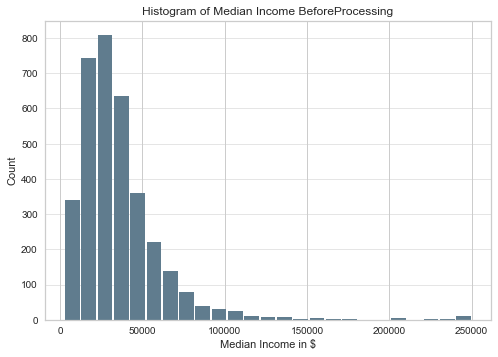

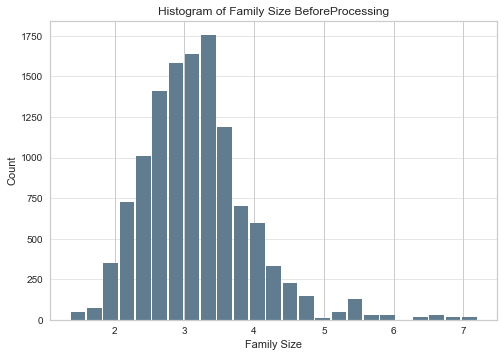

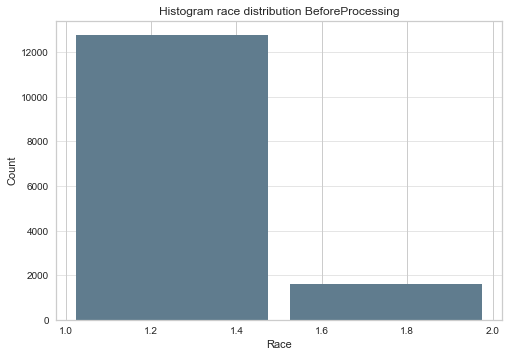

<Figure size 576x396 with 0 Axes>

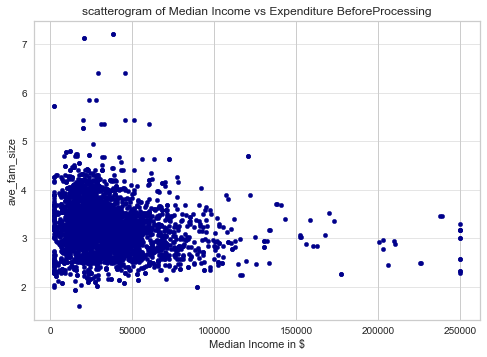

<Figure size 576x396 with 0 Axes>

In [10]:
plotting(datasetupUnprocessed , "BeforeProcessing")

# preProcessing

In [11]:
preProcessing()
showDataHeadAndInfo(dataSetUp,head_Value)


0    1997
1    1219
Name: affordability_ratio, dtype: int64
showing head 15 values
    race_eth_code  median_income  affordability_ratio  ave_fam_size
0               1        23777.0                    0          3.34
1               1        38508.0                    1          3.34
2               1        26192.0                    0          3.34
3               1        22858.0                    0          3.34
4               1        36737.0                    0          3.34
5               2        38641.0                    1          3.34
6               1        32866.0                    0          3.34
7               1        30439.0                    0          3.34
8               1        28184.0                    0          3.34
9               1        16063.0                    0          3.21
10              1        42048.0                    1          3.21
11              1        23858.0                    0          3.21
12              1        28917.0 

# Plotting post Cleanup

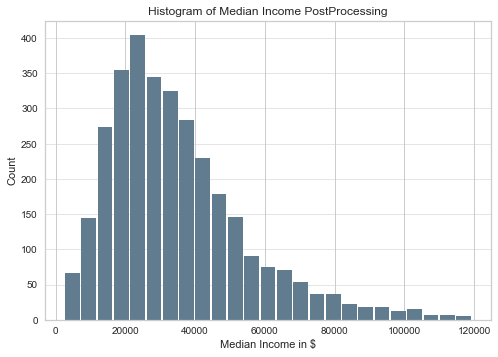

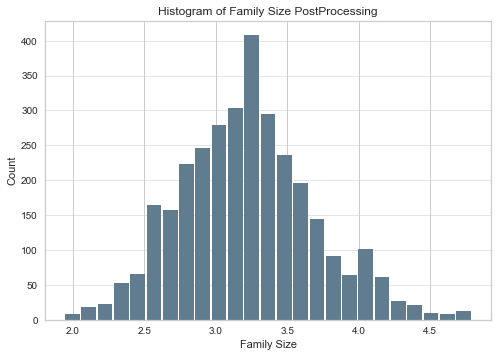

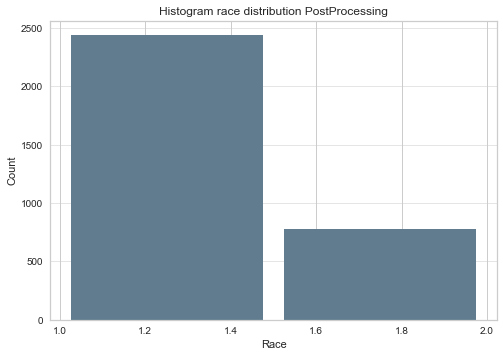

<Figure size 576x396 with 0 Axes>

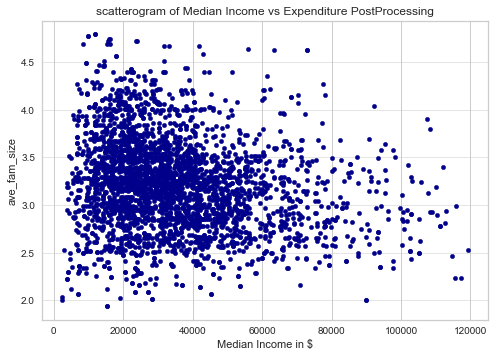

<Figure size 576x396 with 0 Axes>

In [12]:
plotting(dataSetUp, "PostProcessing")

Check Corellation

In [14]:
dataSetUp.corr()

,race_eth_code,median_income,affordability_ratio,ave_fam_size
race_eth_code,1.000000,0.154860,0.183194,-0.119783
median_income,0.154860,1.000000,0.762884,-0.208589
affordability_ratio,0.183194,0.762884,1.000000,-0.357839
ave_fam_size,-0.119783,-0.208589,-0.357839,1.000000


# Check VIF

In [15]:
vifCheck(dataSetUp)

               feature       VIF
0        race_eth_code  8.337837
1        median_income  9.762107
2  affordability_ratio  4.203646
3         ave_fam_size  9.716444


# Predictor Importance

Feature: 0, Score: 0.43403
Feature: 1, Score: 0.00072
Feature: 2, Score: -7.86347


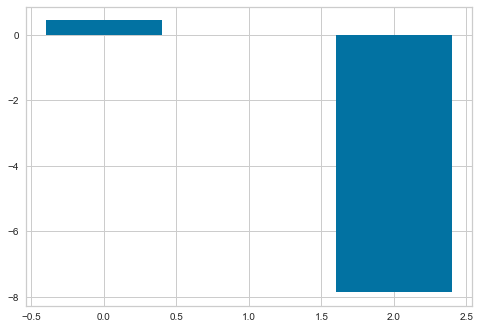

In [16]:
predictorImportance()

# seperate dependent and independent variables

In [17]:
X = dataSetUp.drop(DependentVariable, axis=1)
y = dataSetUp[DependentVariable]

# Pearsons Analysis

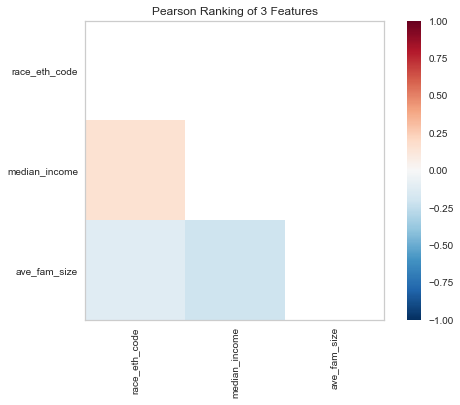

<AxesSubplot:title={'center':'Pearson Ranking of 3 Features'}>

In [18]:
visualizer = Rank2D(algorithm='pearson')
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

# ClassBalance 

In [ ]:
visualizer = ClassBalance(labels=["Cant Afford", "Can Afford"])
visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Split Dataset into train and test dataset

In [ ]:
trainDataset()

# Create a dict of models to use

In [ ]:
dict_classifiers = {
    "rfc": RandomForestClassifier(n_estimators=200),
    "clf": svm.SVC(),
    "mlpc": MLPClassifier(hidden_layer_sizes=(11, 11, 11), max_iter=500,  random_state=1),
    "lr": LogisticRegression(),
}

# Train and Print Details

In [ ]:
for model, model_instantiation in dict_classifiers.items():
    model = model_instantiation
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    # yellow brick
    cm = ConfusionMatrix(model, classes=[0,1])
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.show()
    confusion_Matrix = confusion_matrix(y_test, y_score)
    cm = accuracy_score(y_test, y_score)
    print(f"Printing Model details for : {model}\n"
          f"Printing Confusion Matrix\n{confusion_Matrix}\n"
          f"Printing Classification Report\n {classification_report(y_test, y_score)}\n"
          f"****\n"
          f"End of Model\n"
          f"****\n")